<center><h1>Portfolio and Risk Analytics in Python with pyfolio</h1>
<br>
<h3>Dr. Thomas Wiecki</h3><br>
<h3>Lead Data Scientist</h3>
<img width=40% src="http://i2.wp.com/stuffled.com/wp-content/uploads/2014/09/Quantopian-Logo-EPS-vector-image.png?resize=1020%2C680\">
</center>

# About me

* Lead Data Scientist at Quantopian Inc.
* PhD from Brown university: Bayesian models of brain dysfunction
* Contributor to [PyMC3](https://github.com/pymc-devs/pymc3): Probabilistic Programming in Python
* Twitter: [@twiecki](https://twitter.com/twiecki)

## Why use Python for quant finance?

* Python is a **general purpose language** -> No hodge-podge of perl, bash, matlab, fortran.
* Very easy to learn.

<center> <h2>The Quant Finance PyData Stack</h2>
Source: [Jake VanderPlas: State of the Tools](https://www.youtube.com/watch?v=5GlNDD7qbP4)
<center><img src='pydata_stack-4-finance.jpg' width=50%></center>

## Python in Quantitative Finance

When Quantopian started in 2011, we needed a backtester:

-> Open-sourced Zipline in 2012

When we started to build a crowd-source hedge fund, we needed a better way to evaluate algorithms:

-> Open-sourced pyfolio in 2015

## Announcing pyfolio

* State-of-the-art portfolio and risk analytics
* http://quantopian.github.io/pyfolio/
* Open source and free: Apache v2 license
* Can be used:
   - stand alone
   - with Zipline
   - on Quantopian
   - with PyThalesians

## Using pyfolio stand-alone

## Installation

* Use Anaconda to get a Python system with the full PyData ecosystem.
* `pip install pyfolio`

In [3]:
%matplotlib inline

In [4]:
import pyfolio as pf

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
ERROR:theano.sandbox.cuda:nvcc compiler not found on $PATH. Check your nvcc installation and try again.


## Fetch the daily returns for a stock

In [5]:
stock_rets = pf.utils.get_symbol_rets('FB')
stock_rets.head()

Date
2012-05-21 00:00:00+00:00   -0.109861
2012-05-22 00:00:00+00:00   -0.089039
2012-05-23 00:00:00+00:00    0.032258
2012-05-24 00:00:00+00:00    0.032187
2012-05-25 00:00:00+00:00   -0.033909
Name: FB, dtype: float64

## Tear sheets

Collection of tables and plots.

Various tear sheets based on:
* returns
* positions
* transactions
* periods of market stress
* Bayesian analyses

## To get an idea, here is a returns based tear sheet

Entire data start date: 2012-05-21
Entire data end date: 2015-10-06


Backtest Months: 40
                   Backtest
annual_return          0.36
annual_volatility      0.44
sharpe_ratio           0.81
calmar_ratio           0.74
stability              0.88
max_drawdown          -0.48
omega_ratio            1.17
sortino_ratio          1.55
skewness               1.74
kurtosis              19.10
alpha                  0.20
beta                   1.01

Worst Drawdown Periods
   net drawdown in %  peak date valley date recovery date duration
1              47.90 2012-05-21  2012-09-04    2013-07-25      309
2              22.06 2014-03-10  2014-04-28    2014-07-24       99
3              17.34 2013-10-18  2013-11-25    2013-12-17       43
0              16.57 2015-07-21  2015-08-24           NaT      NaN
4               9.20 2015-03-24  2015-05-12    2015-06-23       66


2-sigma returns daily    -0.054
2-sigma returns weekly   -0.109
dtype: float64


/home/wiecki/miniconda3/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


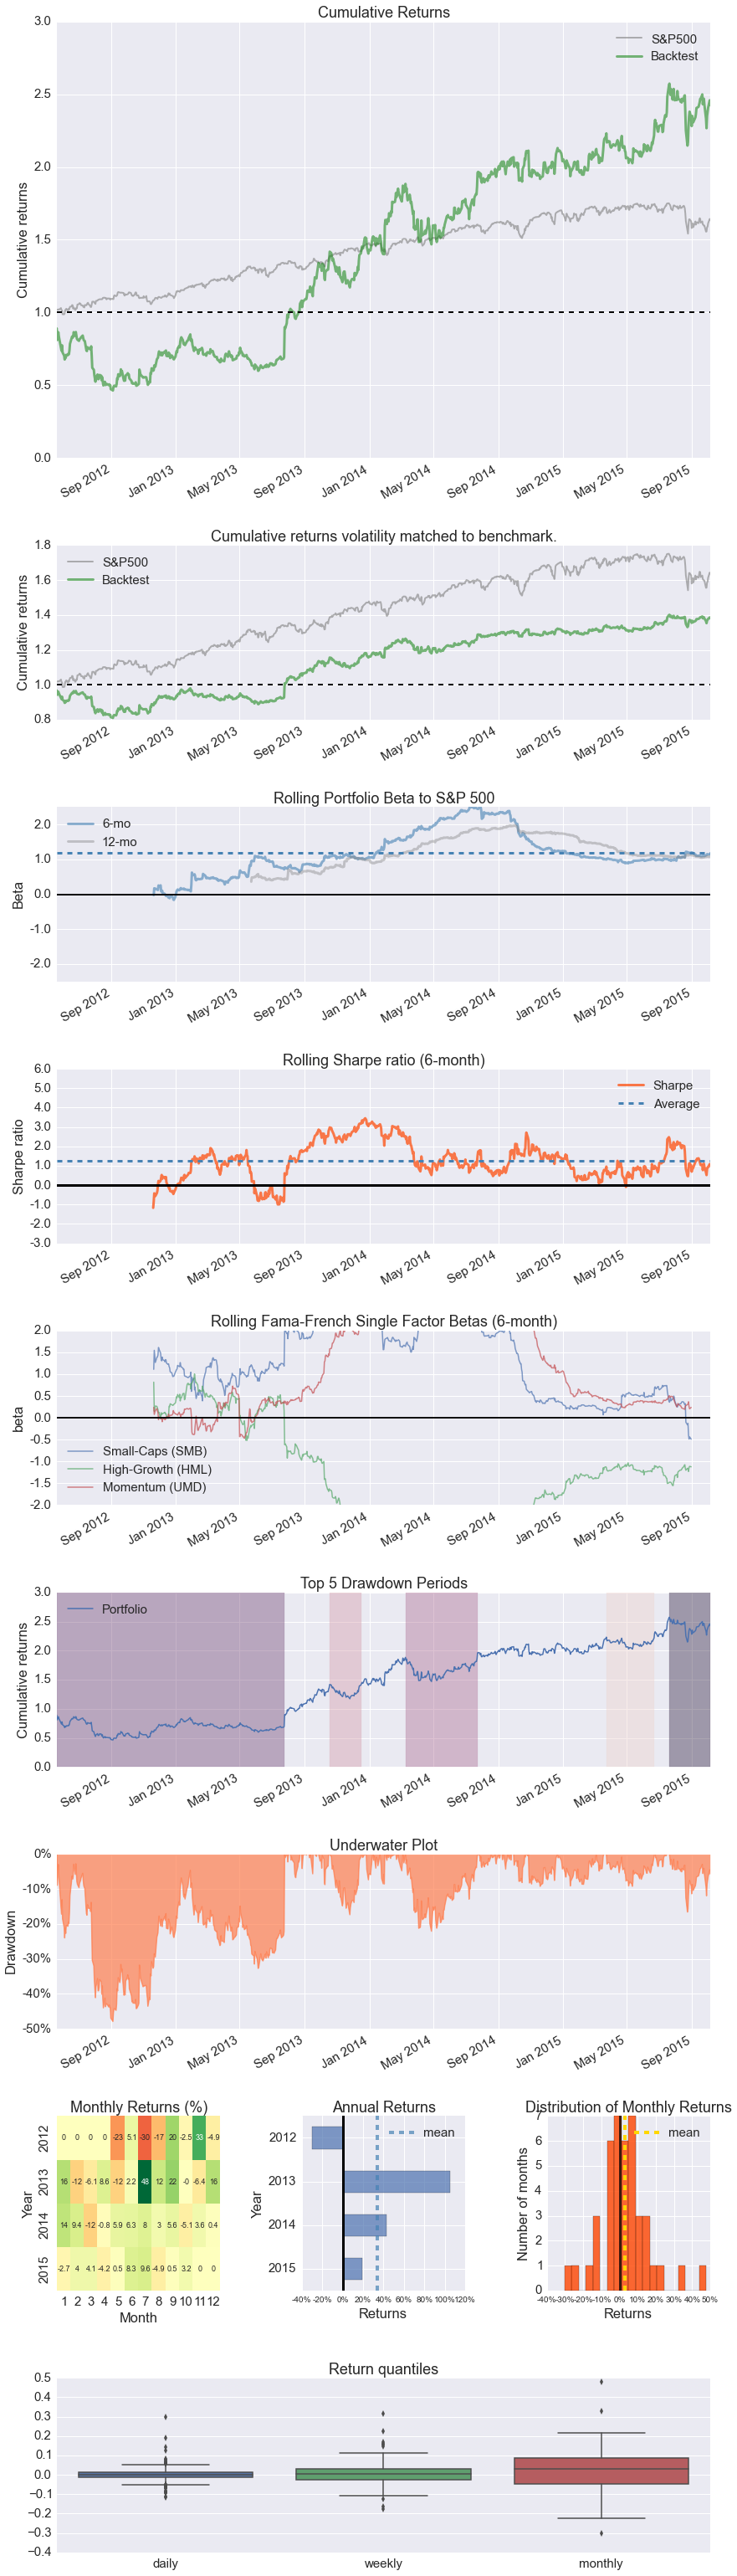

In [6]:
pf.create_returns_tear_sheet(stock_rets)

## Zipline + pyfolio

* Open-source backtester by Quantopian Inc.
* Powers Quantopian.com
* Various models for transaction costs and slippage.

In [7]:
import numpy as np
import pandas as pd

import sys
import logbook
import numpy as np
from datetime import datetime
import pytz

# Import Zipline, the open source backtester
from zipline import TradingAlgorithm
from zipline.data.loader import load_bars_from_yahoo
from zipline.api import order_target, symbol, history, add_history, schedule_function, date_rules, time_rules
from zipline.algorithm import TradingAlgorithm
from zipline.utils.factory import load_from_yahoo
from zipline.finance import commission

In [9]:
# Zipline trading algorithm
# Taken from zipline.examples.olmar
zipline_logging = logbook.NestedSetup([
    logbook.NullHandler(level=logbook.DEBUG),
    logbook.StreamHandler(sys.stdout, level=logbook.INFO),
    logbook.StreamHandler(sys.stderr, level=logbook.ERROR),
])
zipline_logging.push_application()

STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']


# On-Line Portfolio Moving Average Reversion

# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf
def initialize(algo, eps=1, window_length=5):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.last_desired_port = np.ones(algo.m) / algo.m
    algo.eps = eps
    algo.init = True
    algo.days = 0
    algo.window_length = window_length
    algo.add_transform('mavg', 5)

    algo.set_commission(commission.PerShare(cost=0))


def handle_data(algo, data):
    algo.days += 1
    if algo.days < algo.window_length:
        return

    if algo.init:
        rebalance_portfolio(algo, data, algo.b_t)
        algo.init = False
        return

    m = algo.m

    x_tilde = np.zeros(m)
    b = np.zeros(m)

    # find relative moving average price for each asset
    for i, sid in enumerate(algo.sids):
        price = data[sid].price
        # Relative mean deviation
        x_tilde[i] = data[sid].mavg(algo.window_length) / price

    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)

    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm


def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    desired_amount = np.zeros_like(desired_port)
    current_amount = np.zeros_like(desired_port)
    prices = np.zeros_like(desired_port)

    if algo.init:
        positions_value = algo.portfolio.starting_cash
    else:
        positions_value = algo.portfolio.positions_value + \
            algo.portfolio.cash

    for i, sid in enumerate(algo.sids):
        current_amount[i] = algo.portfolio.positions[sid].amount
        prices[i] = data[sid].price

    desired_amount = np.round(desired_port * positions_value / prices)

    algo.last_desired_port = desired_port
    diff_amount = desired_amount - current_amount

    for i, sid in enumerate(algo.sids):
        algo.order(sid, diff_amount[i])


def simplex_projection(v, b=1):
    """Projection vectors to the simplex domain

    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0

    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w

    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> print(proj)
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0

    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w

start = datetime(2004, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2010, 1, 1, 0, 0, 0, 0, pytz.utc)
data = load_from_yahoo(stocks=STOCKS, indexes={}, start=start, end=end)
data = data.dropna()
olmar = TradingAlgorithm(handle_data=handle_data,
                         initialize=initialize,
                         identifiers=STOCKS)
backtest = olmar.run(data)

AMD
CERN
COST
DELL
GPS
INTC
MMM
[2015-10-07 15:16:55.699362] INFO: Performance: Simulated 1511 trading days out of 1511.
[2015-10-07 15:16:55.700336] INFO: Performance: first open: 2004-01-02 14:31:00+00:00
[2015-10-07 15:16:55.701165] INFO: Performance: last close: 2009-12-31 21:00:00+00:00


## Converting data from zipline to pyfolio

In [10]:
returns, positions, transactions, gross_lev = \
    pf.utils.extract_rets_pos_txn_from_zipline(backtest)

In [11]:
positions.columns = STOCKS + ['cash']

## Data structures used by pyfolio

In [12]:
returns.tail()

2009-12-24 00:00:00+00:00    0.000989
2009-12-28 00:00:00+00:00    0.008174
2009-12-29 00:00:00+00:00    0.007428
2009-12-30 00:00:00+00:00    0.002472
2009-12-31 00:00:00+00:00   -0.018984
Name: returns, dtype: float64

In [13]:
positions.tail()

,AMD,CERN,COST,DELL,GPS,INTC,MMM,cash
index,,,,,,,,
2009-12-24 00:00:00+00:00,0.00,0.00000,28116.291654,0.00000,86022.143403,40522.266140,17288.084400,261.648675
2009-12-28 00:00:00+00:00,0.00,0.00000,26444.895165,0.00000,91778.156400,38402.193192,17039.652084,-46.731967
2009-12-29 00:00:00+00:00,0.00,0.00000,18547.461768,0.00000,108639.828380,47874.339058,0.000000,-153.847015
2009-12-30 00:00:00+00:00,3178.44,0.00000,31364.795616,63294.65464,53188.785870,26018.584921,0.000000,-1705.100847
2009-12-31 00:00:00+00:00,44363.44,20816.10101,63315.443592,18114.05960,26346.752400,0.000000,0.000000,-944.218331


In [15]:
transactions.tail()

,txn_volume,txn_shares
2009-12-24 00:00:00+00:00,29064.589481,1381
2009-12-28 00:00:00+00:00,8794.514054,405
2009-12-29 00:00:00+00:00,49996.978324,1765
2009-12-30 00:00:00+00:00,157158.874704,9233
2009-12-31 00:00:00+00:00,189609.809608,11946


## Create all tear-sheets pyfolio has to offer

Entire data start date: 2004-01-02
Entire data end date: 2009-12-31


Backtest Months: 71
                   Backtest
annual_return          0.12
annual_volatility      0.25
sharpe_ratio           0.48
calmar_ratio           0.21
stability              0.01
max_drawdown          -0.60
omega_ratio            1.09
sortino_ratio          0.76
skewness               0.27
kurtosis               4.05
alpha                  0.09
beta                   0.81

Worst Drawdown Periods
   net drawdown in %  peak date valley date recovery date duration
0              59.50 2007-11-06  2008-11-20           NaT      NaN
1              22.33 2006-02-16  2006-08-31    2007-05-21      328
2              12.52 2005-07-28  2005-10-12    2006-01-11      120
3              11.28 2004-11-15  2005-04-28    2005-07-22      180
4               9.44 2007-07-16  2007-08-06    2007-09-04       37


2-sigma returns daily    -0.032
2-sigma returns weekly   -0.065
dtype: float64


/home/wiecki/miniconda3/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


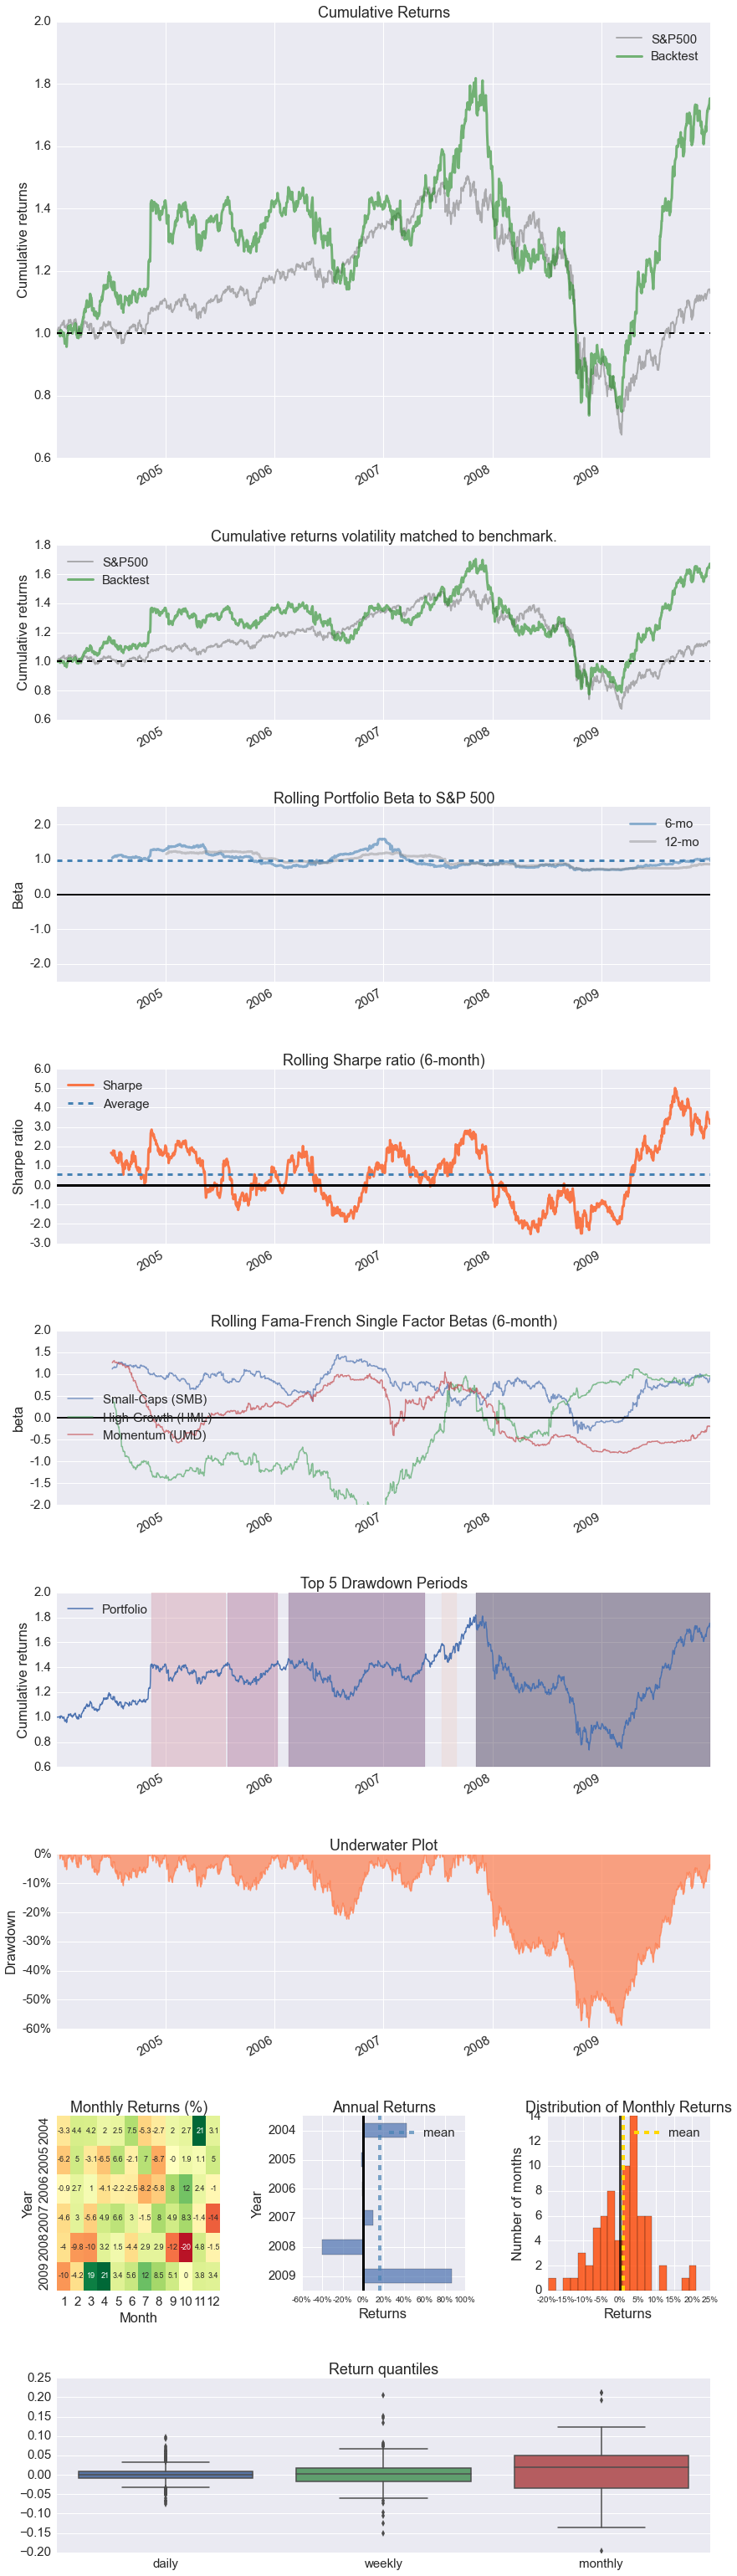


Stress Events
          mean    min    max
Lehmann -0.003 -0.044  0.044
Aug07    0.003 -0.030  0.030
Sept08  -0.006 -0.043  0.040
2009Q1  -0.004 -0.050  0.034
2009Q2   0.007 -0.038  0.062


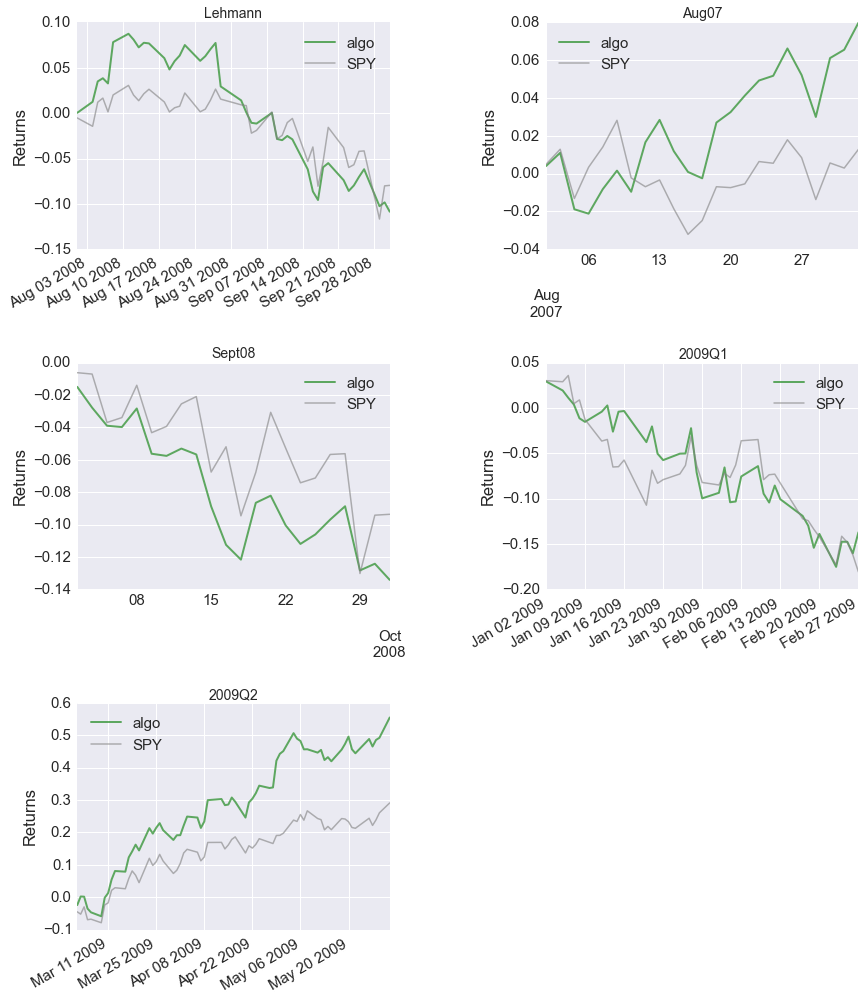



Top 10 long positions of all time (and max%)
['COST' 'MMM' 'CERN' 'DELL' 'AMD' 'INTC' 'GPS']
[ 0.993  0.911  0.845  0.717  0.709  0.666  0.62 ]


Top 10 short positions of all time (and max%)
[]
[]


Top 10 positions of all time (and max%)
['COST' 'MMM' 'CERN' 'DELL' 'AMD' 'INTC' 'GPS']
[ 0.993  0.911  0.845  0.717  0.709  0.666  0.62 ]


All positions ever held
['COST' 'MMM' 'CERN' 'DELL' 'AMD' 'INTC' 'GPS']
[ 0.993  0.911  0.845  0.717  0.709  0.666  0.62 ]




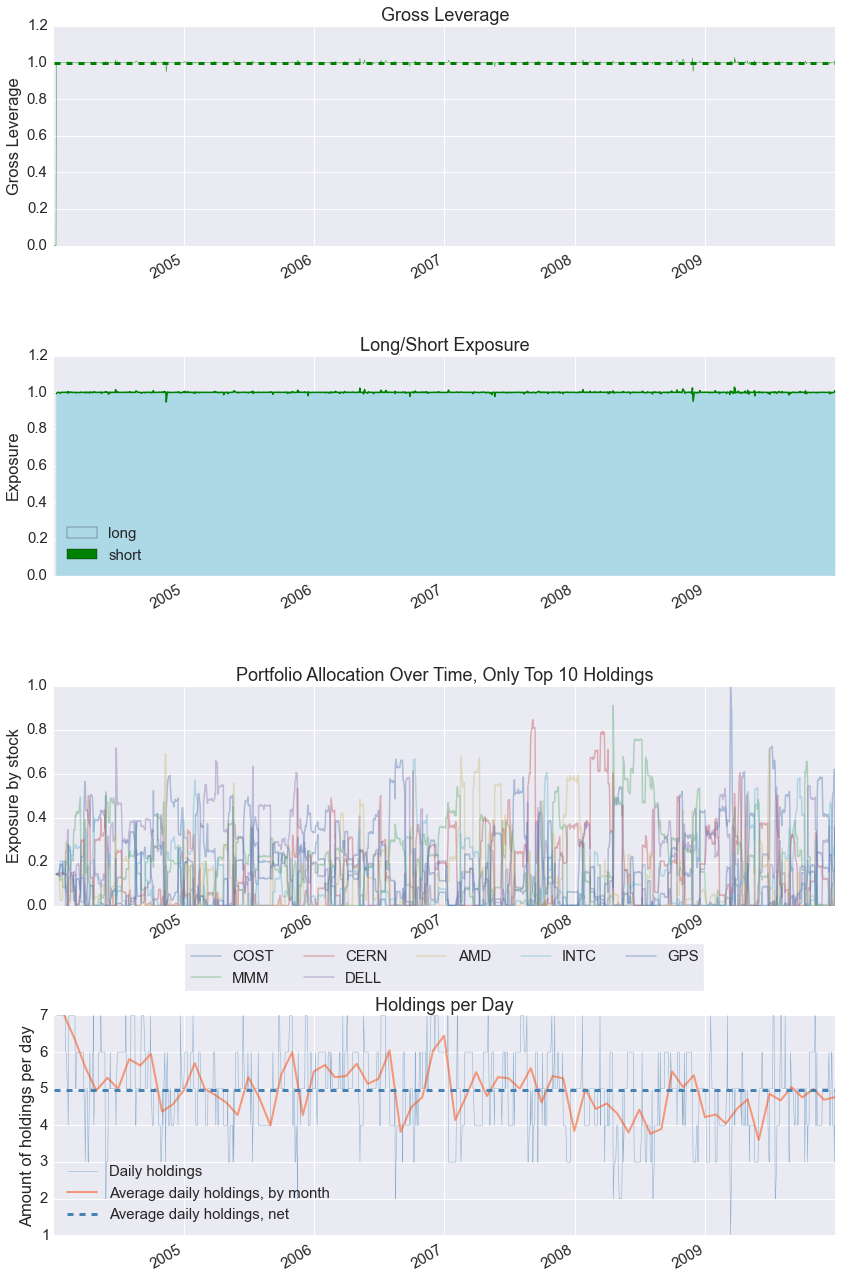

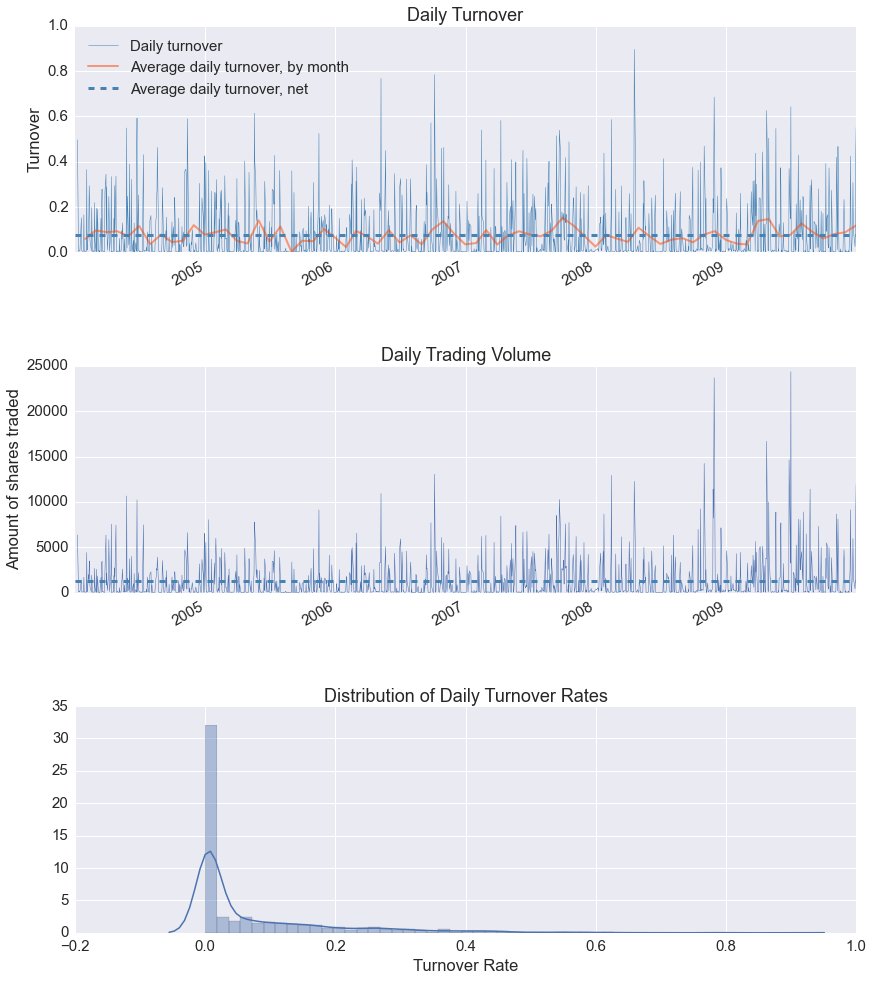

In [16]:
pf.create_full_tear_sheet(returns,
                          positions=positions,
                          transactions=transactions,
                          gross_lev=gross_lev)

## Pyfolio can also be used as a library

Levels of API
* Tear sheets call individual plotting functions in `pyfolio.plotting`
* Plotting functions call individual statistical functions in `pyfolio.timeseries` 

In [17]:
# Show overview of pyfolio.plotting submodule
[f for f in dir(pf.plotting) if 'plot_' in f]

['plot_annual_returns',
 'plot_daily_returns_similarity',
 'plot_daily_turnover_hist',
 'plot_daily_volume',
 'plot_drawdown_periods',
 'plot_drawdown_underwater',
 'plot_exposures',
 'plot_gross_leverage',
 'plot_holdings',
 'plot_monthly_returns_dist',
 'plot_monthly_returns_heatmap',
 'plot_return_quantiles',
 'plot_rolling_beta',
 'plot_rolling_fama_french',
 'plot_rolling_returns',
 'plot_rolling_sharpe',
 'plot_turnover',
 'show_and_plot_top_positions']

In [18]:
pf.timeseries.sharpe_ratio(stock_rets)

0.97590705432532565

## These functions have many more options and detailed descriptions

In [19]:
help(pf.plotting.plot_rolling_returns)

Help on function plot_rolling_returns in module pyfolio.plotting:

plot_rolling_returns(returns, factor_returns=None, live_start_date=None, cone_std=None, legend_loc='best', volatility_match=False, ax=None, **kwargs)
    Plots cumulative rolling returns versus some benchmarks'.
    
    Backtest returns are in green, and out-of-sample (live trading)
    returns are in red.
    
    Additionally, a linear cone plot may be added to the out-of-sample
    returns region.
    
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series, optional
        Daily noncumulative returns of a risk factor.
         - This is in the same style as returns.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading, after
        its backtest period.
    cone_std : float, optional
        The standard deviation to u

## Using pyfolio in Quantopian Research

Go to: https://www.quantopian.com/research/notebooks/Tutorial%20-%20pyfolio.ipynb

## Separating backtest from live-trading

Entire data start date: 2004-01-02
Entire data end date: 2009-12-31


Out-of-Sample Months: 2
Backtest Months: 69
                   Backtest  Out_of_Sample  All_History
annual_return          0.12           0.16         0.12
annual_volatility      0.26           0.22         0.25
sharpe_ratio           0.48           0.74         0.48
calmar_ratio           0.21           2.24         0.21
stability              0.00           0.04         0.01
max_drawdown          -0.60          -0.07        -0.60
omega_ratio            1.09           1.13         1.09
sortino_ratio          0.76           1.19         0.76
skewness               0.28          -0.29         0.27
kurtosis               4.10           0.36         4.05
alpha                  0.09          -0.06         0.09
beta                   0.81           1.20         0.81

Worst Drawdown Periods
   net drawdown in %  peak date valley date recovery date duration
0              59.50 2007-11-06  2008-11-20           NaT      NaN


/home/wiecki/miniconda3/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


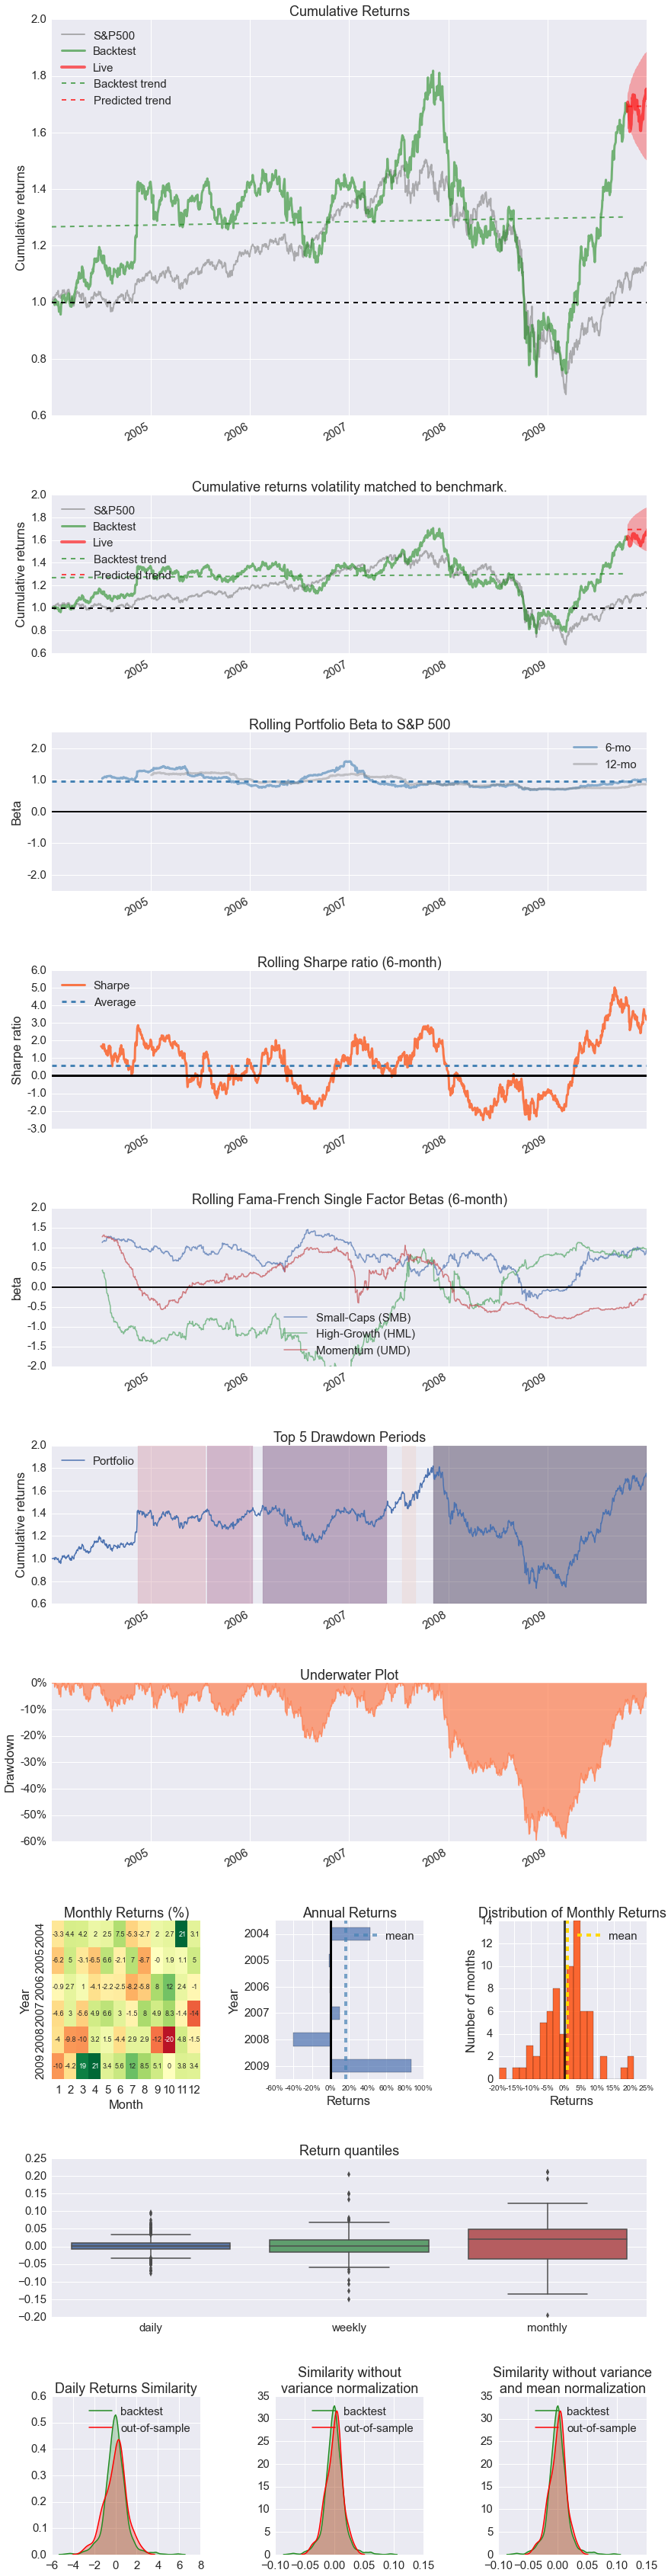

In [24]:
oos_date = '2009-10-21'
pf.create_returns_tear_sheet(returns, live_start_date=oos_date)

## Bayesian analysis in pyfolio

* Sneak-peek into ongoing research.
* Focus is on comparing backtest (in-sample) and forward-test (out-of-sample; OOS).
* Sophisticated statistical modeling taking uncertainty into account.
* Uses T-distribution to model returns (instead of normal).
* Relies on [PyMC3](http://pymc-devs.github.io/pymc3/).

 [-----------------100%-----------------] 2000 of 2000 complete in 8.5 sec

/home/wiecki/miniconda3/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  return f(*args, **kwds)
/home/wiecki/miniconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


 [-----------------100%-----------------] 2000 of 2000 complete in 3.5 sec

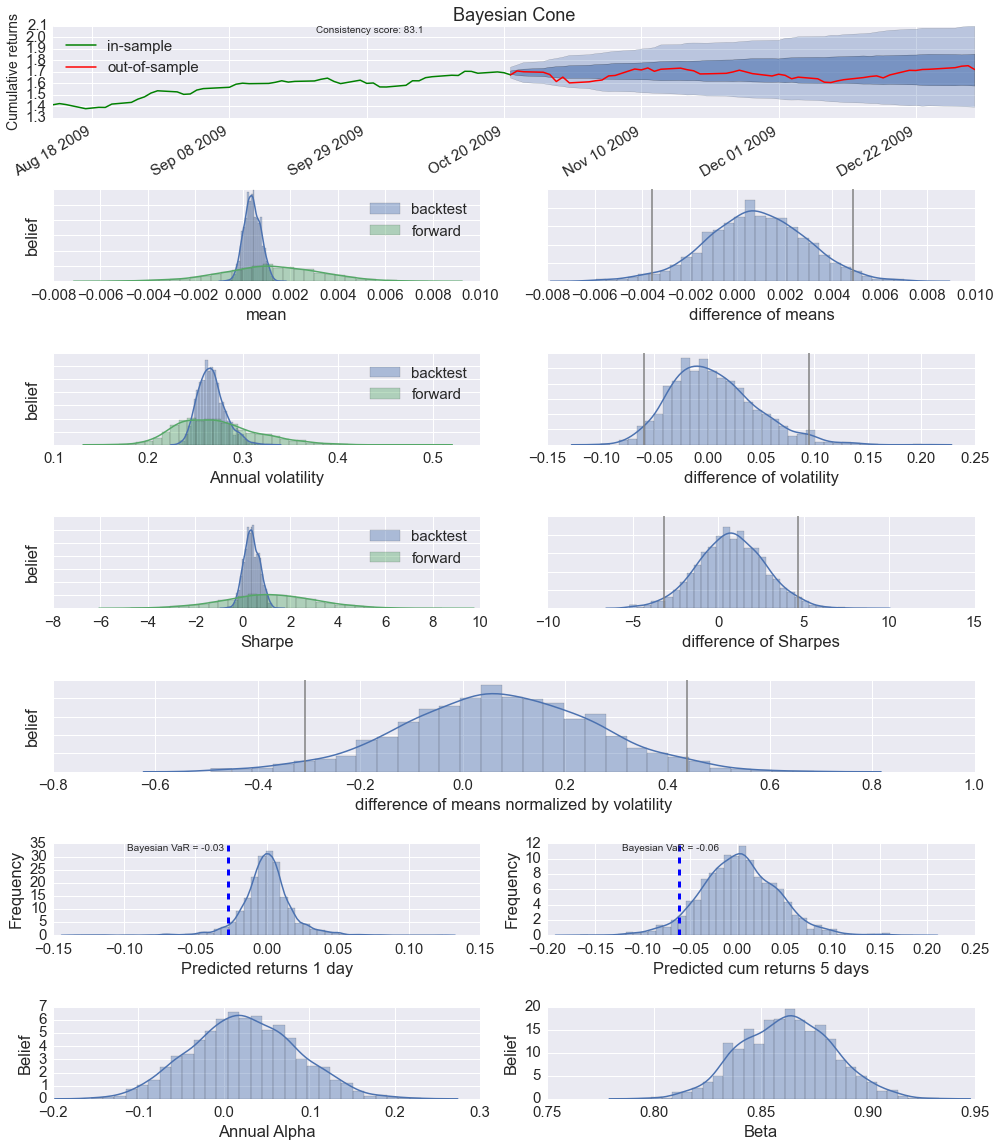

In [23]:
oos_date = '2009-10-21'
pf.create_bayesian_tear_sheet(returns, live_start_date=oos_date)

# For more information:
* Accompanying blog post: [http://blog.quantopian.com/bayesian-cone/](http://blog.quantopian.com/bayesian-cone/)
* Bayesian Methods for Hackers: [http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
* PyMC3: [http://pymc-devs.github.io/pymc3](http://pymc-devs.github.io/pymc3)

# Future of pyfolio

* Round-trip analysis of trades (from open to close of a position)
* Instrument and sector based analysis (performance attribution)
* Cumulative returns under various degrees of slippage
<img src='slippage.png' width=50%>

# Summary

* Pyfolio bundles various useful analyses and includes advanced statistical modeling.
* Jess Stauth's webinar: https://www.youtube.com/watch?v=-VmZAlBWUko
* Still young -- please contribute: https://github.com/quantopian/pyfolio/labels/help%20wanted
* Bugs: https://github.com/quantopian/pyfolio/issues
* Twitter: [@twiecki](https://twitter.com/twiecki)